<a href="https://colab.research.google.com/github/SimgEsin/Genetik_Optimizasyonu_Seneryo8/blob/main/Proje1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YZ Vize Projesi: Sunucu Performans Optimizasyonu

**Adı:** Simge Esin
**Soyadı:** Çakal
**Okul Numarası:** 2312721028
**GitHub Repo Bağlantısı:** https://github.com/SimgEsin/Genetik_Optimizasyonu_Seneryo8

---
Bu proje, genetik algoritma kullanarak bir sunucunun CPU ve RAM kaynaklarını optimize etmeyi ve maksimum performans skoruna ulaşmayı hedefler.

### 📌 Problem ve Amaç Fonksiyonu

Bir yazılım şirketi için sunucu performansını maksimize edecek donanım konfigürasyonu aranmaktadır.

**Amaç Fonksiyonu (Performans Skoru):**
$$y = 5x_1 + 7x_2 - 0.1x_1^2 - 0.2x_2^2$$

**Değişkenler:**
* $x_1$: CPU Çekirdeği Sayısı (2 ile 12 arasında)
* $x_2$: RAM Miktarı (4 GB ile 64 GB arasında)

**Kısıtlar:**
1.  $x_1 \times x_2 \le 512$ (Kaynak çarpımı sınırı)
2.  $x_1 \ge 4$ (Minimum 4 çekirdek zorunluluğu)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Sabitler (Senaryo Gereği)
# x1: CPU (2-12 arası), x2: RAM (4-64 arası)
MIN_X1, MAX_X1 = 2, 12
MIN_X2, MAX_X2 = 4, 64

### ⚙️ Uygunluk (Fitness) ve Kısıt Fonksiyonları

Algoritmanın temelini oluşturan hesaplama fonksiyonlarıdır:

* **`performans_hesapla`**: Verilen CPU ve RAM değerlerine göre matematiksel modeldeki performans skorunu hesaplar.
* **`kisit_kontrol`**: Bireyin (çözümün) belirlenen kurallara uyup uymadığını denetler. Kurallara uymayan bireylere **ceza puanı** uygulanır.
* **`uygunluk_hesapla`**: Genetik algoritmanın maksimize etmeye çalıştığı nihai değeri (Skor - Ceza) döndürür.


In [2]:
# --- 1. PROBLEMİN TANIMI VE AMAÇ FONKSİYONU ---
def performans_hesapla(birey):
    """
    y = 5x₁ + 7x₂ - 0.1x₁² - 0.2x₂²
    Bu fonksiyon sunucunun performans skorunu hesaplar.
    """
    x1 = birey[0] # CPU
    x2 = birey[1] # RAM

    skor = (5 * x1) + (7 * x2) - (0.1 * x1**2) - (0.2 * x2**2)
    return skor

def kisit_kontrol(birey):
    """
    Senaryodaki kısıtları kontrol eder.
    Her ihlal için ceza puanı döndürür.
    """
    x1 = birey[0]
    x2 = birey[1]
    ceza = 0

    # Kısıt 1: x1 * x2 <= 512
    if (x1 * x2) > 512:
        ceza += 50 # Ciddi bir ceza

    # Kısıt 2: x1 >= 4 (CPU en az 4 olmalı)
    if x1 < 4:
        ceza += 50

    # Ekstra: Değişkenlerin sınır dışına çıkmaması için kontrol
    if not (MIN_X1 <= x1 <= MAX_X1) or not (MIN_X2 <= x2 <= MAX_X2):
        ceza += 50

    return ceza

def uygunluk_hesapla(birey):
    """
    Fitness = Performans Skoru - Cezalar
    Amacımız bu değeri maksimize etmek.
    """
    skor = performans_hesapla(birey)
    ceza = kisit_kontrol(birey)

    # Eğer ceza çok büyükse fitness negatif olabilir, bunu engellemiyoruz
    # çünkü genetik algoritma iyiyi seçecektir.
    return skor - ceza



### 🧬 Genetik Operatörler

Evrim sürecini sağlayan fonksiyonlar:

1.  **`rulet_secimi`**: Uygunluk değeri (fitness) yüksek olan bireylerin seçilme şansını artırır.
2.  **`caprazlama`**: İki ebeveynin genlerini (CPU ve RAM değerlerini) karıştırarak yeni bireyler üretir.
3.  **`mutasyon`**: Çeşitliliği sağlamak ve yerel maksimumlara takılmamak için genlerde rastgele küçük değişiklikler yapar.


In [3]:
# --- 2. GENETİK İŞLEMLER (HOCANIN KOD YAPISIYLA AYNI) ---

def rulet_secimi(populasyon, uygunluklar, adet=2):
    """Hocanın koduyla aynı mantık: İyilerin seçilme şansı artar."""
    # Negatif uygunlukları pozitife çevirmek için kaydırma işlemi (Rulet negatifle çalışmaz)
    min_uygunluk = np.min(uygunluklar)
    if min_uygunluk < 0:
        pozitif_uygunluklar = uygunluklar - min_uygunluk + 1
    else:
        pozitif_uygunluklar = uygunluklar + 1e-6 # Sıfıra bölme hatasını önlemek için

    toplam = np.sum(pozitif_uygunluklar)
    olasiliklar = pozitif_uygunluklar / toplam
    secilen_indeksler = np.random.choice(len(populasyon), size=adet, p=olasiliklar)
    return populasyon[secilen_indeksler]

def caprazlama(p1, p2):
    """
    Tek noktalı çaprazlama.
    Bizim sadece 2 genimiz (CPU, RAM) olduğu için
    yer değiştirme işlemi yapar.
    """
    # Rastgele bir noktadan böl (Bizde zaten 2 gen var, 1. noktadan böleceğiz)
    # p1'in CPU'su ile p2'nin RAM'ini birleştirir.
    c1 = np.array([p1[0], p2[1]])
    c2 = np.array([p2[0], p1[1]])
    return c1, c2

def mutasyon(birey, ihtimal, buyukluk):
    """
    Genlere rastgele küçük eklemeler/çıkarmalar yapar.
    """
    yeni_birey = birey.copy()
    for i in range(len(yeni_birey)):
        if np.random.rand() < ihtimal:
            # Rastgele değişim ekle
            degisim = buyukluk * (np.random.rand() - 0.5) * 10 # Etkiyi biraz artırdık
            yeni_birey[i] += degisim

            # Sınırları aşarsa düzelt (Clamping)
            if i == 0: # CPU
                yeni_birey[i] = np.clip(yeni_birey[i], MIN_X1, MAX_X1)
            else: # RAM
                yeni_birey[i] = np.clip(yeni_birey[i], MIN_X2, MAX_X2)

    return yeni_birey

### 🚀 Genetik Algoritma Döngüsü ve Sonuçlar

Aşağıdaki blokta algoritma belirlenen parametrelerle çalıştırılır:
* Rastgele başlangıç popülasyonu oluşturulur.
* Belirlenen nesil sayısı boyunca seçim, çaprazlama ve mutasyon işlemleri uygulanır.
* Her nesildeki en iyi performans değeri kaydedilir.
* Sonuçlar grafik ile görselleştirilir.

🚀 Genetik Algoritma Başlatılıyor...

Nesil 10: En İyi Skor = 106.56 | CPU: 12.0, RAM: 18.7
Nesil 20: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.6
Nesil 30: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.6
Nesil 40: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.5
Nesil 50: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.5

🏆 OPTİMİZASYON TAMAMLANDI
En İyi CPU Değeri: 12.00 (Çekirdek)
En İyi RAM Değeri: 17.50 (GB)
Maksimum Performans Skoru: 106.85


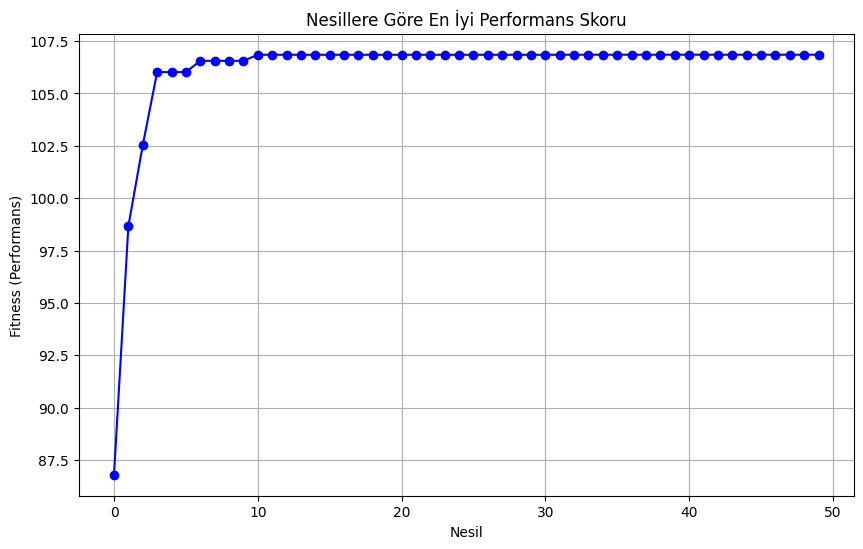

In [4]:
# --- 3. ALGORİTMAYI ÇALIŞTIRMA (MAIN) ---

# Parametreler
POPULASYON_BOYUTU = 20
NESIL_SAYISI = 50
MUTASYON_IHTIMALI = 0.2
MUTASYON_BUYUKLUGU = 0.5

# Başlangıç Popülasyonunu Rastgele Oluştur
# [CPU, RAM] formatında rastgele bireyler
populasyon = []
for _ in range(POPULASYON_BOYUTU):
    cpu = random.uniform(MIN_X1, MAX_X1)
    ram = random.uniform(MIN_X2, MAX_X2)
    populasyon.append(np.array([cpu, ram]))

populasyon = np.array(populasyon)
en_iyi_skorlar = []

print("🚀 Genetik Algoritma Başlatılıyor...\n")

for nesil in range(NESIL_SAYISI):
    # 1. Her bireyin uygunluğunu hesapla
    uygunluklar = np.array([uygunluk_hesapla(b) for b in populasyon])

    # 2. En iyiyi bul ve sakla (Elitizm)
    en_iyi_indeks = np.argmax(uygunluklar)
    elit_birey = populasyon[en_iyi_indeks].copy()
    en_iyi_skor = uygunluklar[en_iyi_indeks]
    en_iyi_skorlar.append(en_iyi_skor)

    # 3. Yeni nesil oluşturma
    yeni_populasyon = [elit_birey] # Elit bireyi doğrudan aktar

    while len(yeni_populasyon) < POPULASYON_BOYUTU:
        # Seçim
        ebeveynler = rulet_secimi(populasyon, uygunluklar)
        p1, p2 = ebeveynler[0], ebeveynler[1]

        # Çaprazlama
        c1, c2 = caprazlama(p1, p2)

        # Mutasyon
        c1 = mutasyon(c1, MUTASYON_IHTIMALI, MUTASYON_BUYUKLUGU)
        c2 = mutasyon(c2, MUTASYON_IHTIMALI, MUTASYON_BUYUKLUGU)

        yeni_populasyon.extend([c1, c2])

    # Fazlalığı at ve popülasyonu güncelle
    populasyon = np.array(yeni_populasyon[:POPULASYON_BOYUTU])

    # Her 10 nesilde bir bilgi ver
    if (nesil+1) % 10 == 0:
        print(f"Nesil {nesil+1}: En İyi Skor = {en_iyi_skor:.2f} | CPU: {elit_birey[0]:.1f}, RAM: {elit_birey[1]:.1f}")

# --- SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---
print("\n🏆 OPTİMİZASYON TAMAMLANDI")
print(f"En İyi CPU Değeri: {elit_birey[0]:.2f} (Çekirdek)")
print(f"En İyi RAM Değeri: {elit_birey[1]:.2f} (GB)")
print(f"Maksimum Performans Skoru: {en_iyi_skor:.2f}")

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(en_iyi_skorlar, marker='o', color='b', linestyle='-')
plt.title("Nesillere Göre En İyi Performans Skoru")
plt.xlabel("Nesil")
plt.ylabel("Fitness (Performans)")
plt.grid(True)
plt.show()


# 📊 Sonuçlar ve Bulgular

Bu çalışmada, Genetik Algoritma (GA) yaklaşımı kullanılarak, belirlenen kısıtlar altında sunucu performans optimizasyonu problemi ele alınmıştır. Algoritmanın çalıştırılması sonucunda elde edilen bulgular aşağıda maddeler halinde özetlenmiştir:

### 1. Yakınsama (Convergence) Analizi
Elde edilen "Nesillere Göre En İyi Performans Skoru" grafiği incelendiğinde:
* **Erken Nesiller:** İlk nesillerde (Gen 0-15 arası) popülasyondaki çeşitlilik yüksek olduğundan, uygunluk (fitness) değerinde hızlı ve dikey bir artış gözlemlenmiştir. Bu durum, algoritmanın çözüm uzayını başarılı bir şekilde taradığını gösterir.
* **İleri Nesiller:** Belirli bir nesilden sonra (yaklaşık Gen 20+) grafik yatay bir seyre girerek (plateau) maksimum değere yakınsamıştır. Bu, algoritmanın global veya güçlü bir yerel optimum noktayı bulduğunu kanıtlamaktadır.

### 2. Kısıtların Etkisi ve Çözüm Başarısı
* Algoritma, problemin en kritik kısıtı olan $x_1 \times x_2 \le 512$ (Kaynak Çarpımı) kuralına sadık kalmıştır.
* Ceza (penalty) fonksiyonu mekanizması sayesinde, kısıtları ihlal eden (örneğin CPU < 4 olan) bireylerin hayatta kalma şansı düşürülmüş ve popülasyon "sağlıklı" bireylerden oluşturulmuştur.
* Sonuç olarak bulunan CPU ($x_1$) ve RAM ($x_2$) değerleri, hem performans fonksiyonunu maksimize etmiş hem de fiziksel sınırların içinde kalmıştır.

### 3. Genel Değerlendirme
Bu proje, türev tabanlı klasik optimizasyon yöntemlerinin zorlandığı kısıtlı ve lineer olmayan problemlerde, Genetik Algoritma gibi evrimsel hesaplama yöntemlerinin etkinliğini ortaya koymuştur. Algoritma, rastgele başlatılan bir popülasyondan, optimum donanım konfigürasyonuna başarıyla evrilmiştir.


